# Excess deaths due to COVID-19

In [1]:
import pandas as pd
from pymc_extras.prior import Prior

import causalpy as cp

In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
seed = 42

## Load data

In [3]:
df = (
    cp.load_data("covid")
    .assign(date=lambda x: pd.to_datetime(x["date"]))
    .set_index("date")
)

treatment_time = pd.to_datetime("2020-01-01")
df.head()

,temp,deaths,year,month,t,pre
date,,,,,,
2006-01-01,3.8,49124,2006,1,0,True
2006-02-01,3.4,42664,2006,2,1,True
2006-03-01,3.9,49207,2006,3,2,True
2006-04-01,7.4,40645,2006,4,3,True
2006-05-01,10.7,42425,2006,5,4,True


The columns are:

* `date` + `year`: self explanatory
* `month`: month, numerically encoded. Needs to be treated as a categorical variable
* `temp`: average UK temperature (Celsius)
* `t`: time
* `pre`: boolean flag indicating pre or post intervention

## Run the analysis

In this example we are going to standardize the data. So we have to be careful in how we interpret the inferred regression coefficients, and the posterior predictions will be in this standardized space.

:::{note}
The `random_seed` keyword argument for the PyMC sampler is not necessary. We use it here so that the results are reproducible.
:::

In [4]:
model = cp.pymc_models.LinearRegression(
    sample_kwargs={"random_seed": seed},
    priors={
        "beta": Prior(
            "Normal",
            mu=[42_000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            sigma=10_000,
            dims=["treated_units", "coeffs"],
        ),
        "y_hat": Prior(
            "Normal",
            sigma=Prior("HalfNormal", sigma=10_000, dims=["treated_units"]),
            dims=["obs_ind", "treated_units"],
        ),
    },
)

In [5]:
result = cp.InterruptedTimeSeries(
    df,
    treatment_time,
    formula="standardize(deaths) ~ 0 + standardize(t) + C(month) + standardize(temp)",
    model=model,
)

Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [beta, y_hat_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


Sampling: [beta, y_hat, y_hat_sigma]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


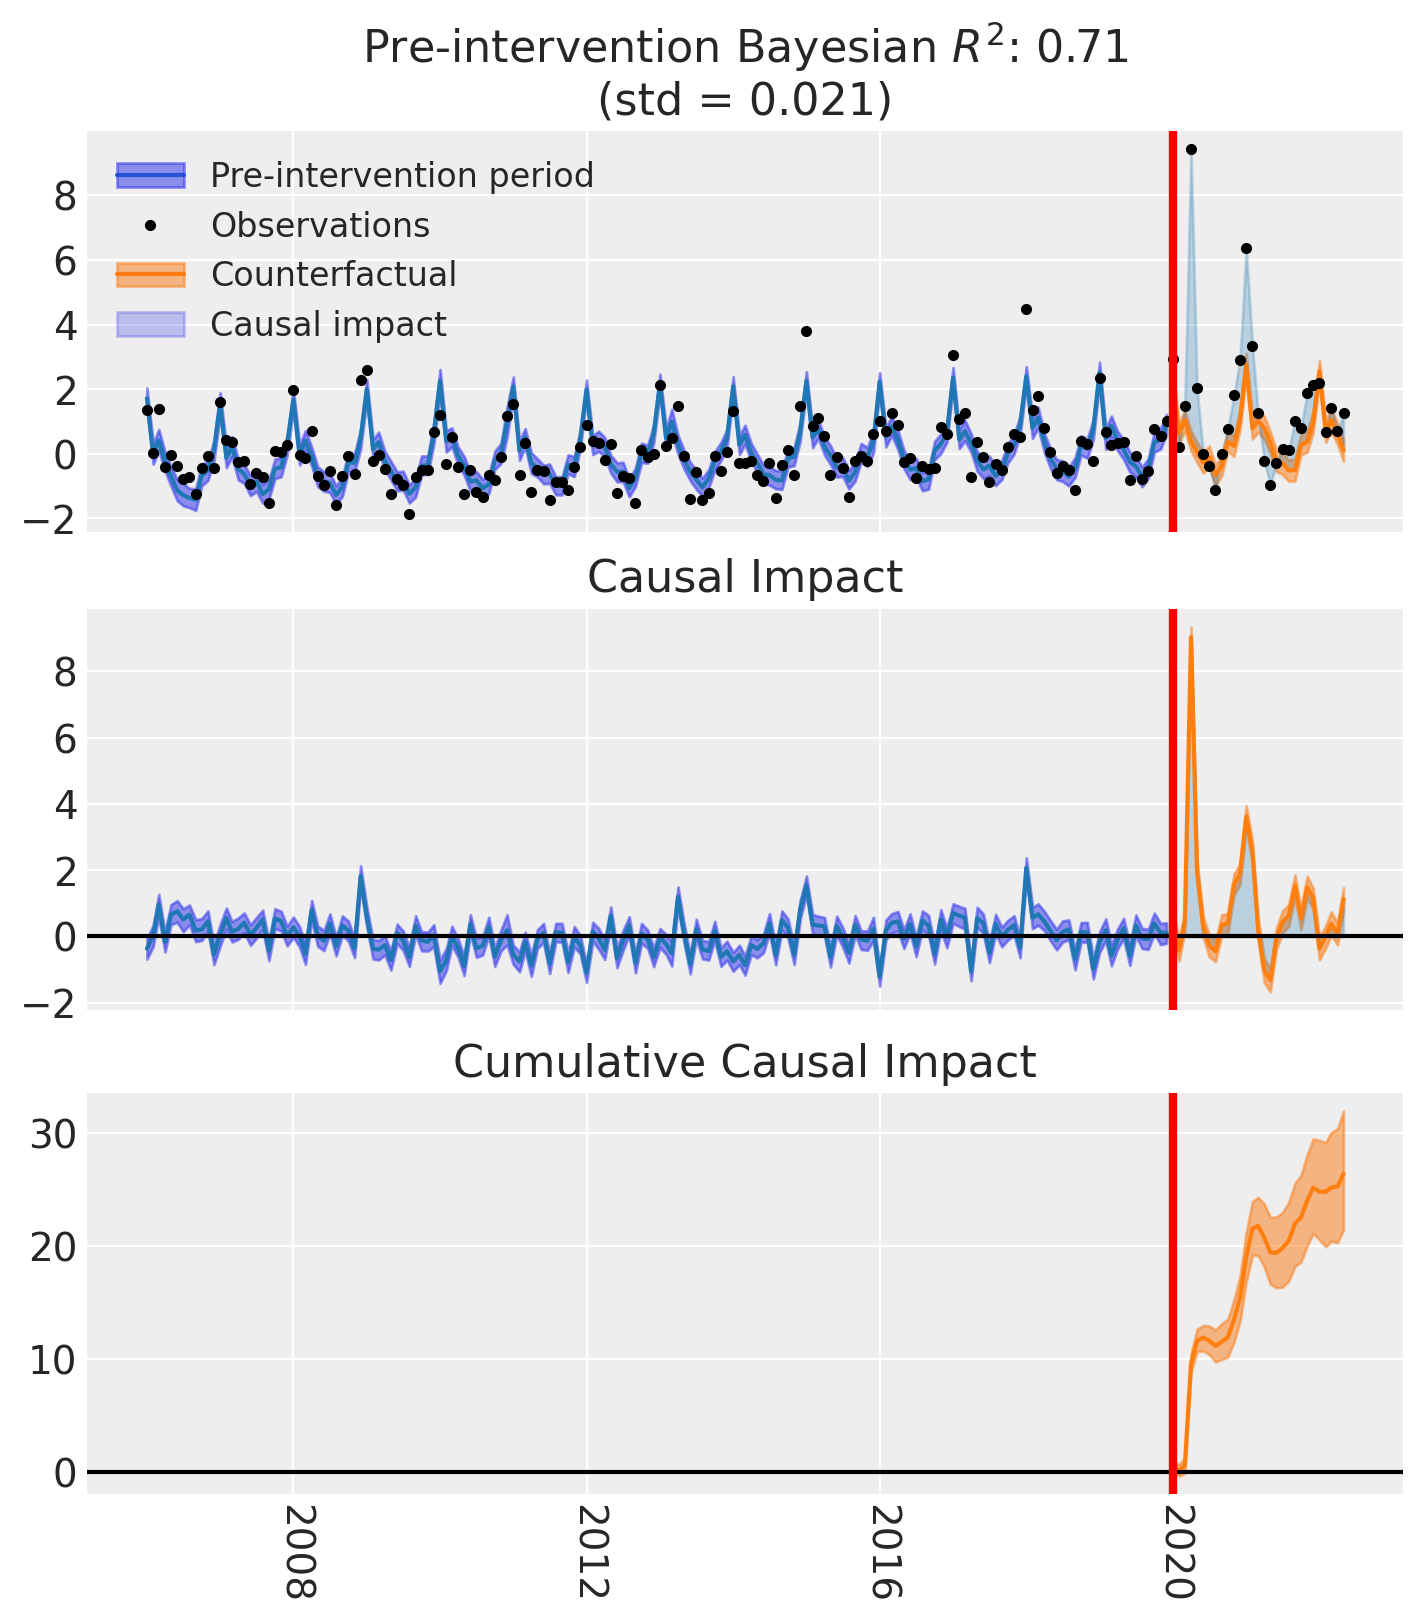

In [6]:
fig, ax = result.plot()

In [7]:
result.summary()

==================================Pre-Post Fit==================================
Formula: standardize(deaths) ~ 0 + standardize(t) + C(month) + standardize(temp)
Model coefficients:
    C(month)[1]        1.6, 94% HDI [1.1, 2]
    C(month)[2]        -0.21, 94% HDI [-0.66, 0.23]
    C(month)[3]        0.26, 94% HDI [-0.12, 0.62]
    C(month)[4]        -0.037, 94% HDI [-0.32, 0.25]
    C(month)[5]        -0.15, 94% HDI [-0.45, 0.14]
    C(month)[6]        -0.2, 94% HDI [-0.61, 0.2]
    C(month)[7]        -0.015, 94% HDI [-0.52, 0.5]
    C(month)[8]        -0.41, 94% HDI [-0.86, 0.068]
    C(month)[9]        -0.44, 94% HDI [-0.81, -0.049]
    C(month)[10]       -0.06, 94% HDI [-0.34, 0.23]
    C(month)[11]       -0.37, 94% HDI [-0.69, -0.042]
    C(month)[12]       0.067, 94% HDI [-0.35, 0.48]
    standardize(t)     0.23, 94% HDI [0.16, 0.31]
    standardize(temp)  -0.45, 94% HDI [-0.75, -0.17]
    y_hat_sigma        0.56, 94% HDI [0.5, 0.62]


## Effect Summary Reporting

For decision-making, you often need a concise summary of the causal effect with key statistics. The `effect_summary()` method provides a decision-ready report with average and cumulative effects, HDI intervals, tail probabilities, and relative effects. This provides a comprehensive summary without manual post-processing.

:::{note}
Note that in this example, the data has been standardized, so the effect estimates are in standardized units. When interpreting the results, keep in mind that the effects are relative to the standardized scale of the outcome variable.
:::


In [8]:
# Generate effect summary for the full post-period
stats = result.effect_summary()
stats.table

,mean,median,hdi_lower,hdi_upper,p_gt_0,relative_mean,relative_hdi_lower,relative_hdi_upper
average,0.909767,0.909569,0.723887,1.099395,1.0,179.228024,90.209658,289.949146
cumulative,26.383244,26.377487,20.992726,31.882461,1.0,179.228028,90.209659,289.949154


In [9]:
# View the prose summary
print(stats.text)

During the post-period (2020-01-01 00:00:00 to 2022-05-01 00:00:00), the response variable had an average value of approx. 1.45. By contrast, in the absence of an intervention, we would have expected an average response of 0.54. The 95% interval of this counterfactual prediction is [0.35, 0.72]. Subtracting this prediction from the observed response yields an estimate of the causal effect the intervention had on the response variable. This effect is 0.91 with a 95% interval of [0.72, 1.10].

Summing up the individual data points during the post-period, the response variable had an overall value of 41.93. By contrast, had the intervention not taken place, we would have expected a sum of 15.55. The 95% interval of this prediction is [10.05, 20.94].

The 95% HDI of the effect [0.72, 1.10] does not include zero. The posterior probability of a increase is 1.000. Relative to the counterfactual, the effect represents a 179.23% change (95% HDI [90.21%, 289.95%]).

This analysis assumes that th

In [10]:
# You can also analyze a specific time window, e.g., the first 6 months of 2020
stats_window = result.effect_summary(
    window=(pd.to_datetime("2020-01-01"), pd.to_datetime("2020-06-30"))
)
stats_window.table

,mean,median,hdi_lower,hdi_upper,p_gt_0,relative_mean,relative_hdi_lower,relative_hdi_upper
average,1.983175,1.984556,1.788543,2.180481,1.0,291.671745,192.699140,416.684473
cumulative,11.899051,11.907338,10.731261,13.082884,1.0,291.671749,192.699142,416.684480


We can get nicely formatted tables from our integration with the [maketables](https://github.com/py-econometrics/maketables) package.

In [ ]:
from maketables import ETable

ETable(result, coef_fmt="b:.3f")